In [1]:
import tensorflow as tf
import os
import pickle
import pandas as pd
import numpy as np

In [20]:
def get_testing_data(directory,min_length,window_size):
    X = []
    y = []
    n = 60//window_size
    for f in os.listdir(directory):
        if f[0]=='.':
            continue
        data = pickle.load(open(directory+f,'rb'))
        if data.shape[0]//n<min_length:
            continue
        X.append(np.concatenate(list(data['data'])))
        y.extend([f]*data.shape[0])
    return np.concatenate(X),np.array(y)

window_size = 20
activity = 'std'
n_user  = 338
min_length = 100
data_directory = './data/'+str(window_size)+'/'+activity+'/testing/'
model_directory = './models/'+str(window_size)+'/'+activity+'/'+str(n_user)+'/'
train_lengths = os.listdir(model_directory)
X,y = get_testing_data(data_directory,min_length,window_size)
save_directory = './predictions/'+str(window_size)+'/'+activity+'/'+str(n_user)+'/'
result_directory = './results/'
if not os.path.isdir(save_directory):
    os.makedirs(save_directory)

In [21]:
import tensorflow as tf
gpus = tf.config.experimental.list_physical_devices('GPU')
if gpus:
  # Restrict TensorFlow to only use the first GPU
    try:
        tf.config.experimental.set_visible_devices(gpus[0], 'GPU')
        logical_gpus = tf.config.experimental.list_logical_devices('GPU')
        print(len(gpus), "Physical GPUs,", len(logical_gpus), "Logical GPU")
    except RuntimeError as e:
        # Visible devices must be set before GPUs have been initialized
        print(e)

4 Physical GPUs, 1 Logical GPU


In [ ]:
from sklearn.metrics import accuracy_score
def get_dictfilename(a):
    a = a.replace('trainedmodel','userdict').replace('hdf5','p')
    return a

def get_predictions(df):
    indexes = np.array(list(df['index']))
    y_pred = model.predict(X[indexes])
    df['y_prob'] = list(y_pred)
    df['y_pred'] = y_pred.argmax(axis=1)
    return df
    

for f in list(os.listdir(model_directory)):
    model_files = [model_directory+f+'/'+a for a in os.listdir(model_directory+f) if a[-1]=='5']
    dict_files = [get_dictfilename(a) for a in model_files]
    pairs = list(zip(model_files,dict_files))
    predictions_all = []
    for i,a in enumerate(pairs):
        m_name,d_name = a
        user_dict = pickle.load(open(d_name,'rb'))
        y_final = np.array([user_dict[a] for a in y])
        index_df = pd.DataFrame({'user':y,'y':y_final,'index':np.arange(len(y))})
        model = tf.keras.models.load_model(m_name)
        predictions = index_df.groupby('user',as_index=False).apply(get_predictions)
        predictions['iteration'] = i
        predictions_all.append(predictions)
    predictions_all = pd.concat(predictions_all)
    pickle.dump(predictions_all,open(save_directory+f,'wb'))

In [3]:
from sklearn.metrics import accuracy_score
from scipy.stats import mode
# from joblib import Parallel,delayed
# def get_score(df):
#     df['y_prob'] = df['y_prob'].apply(lambda a:a.reshape(1,-1))
#     user = df['user'].values[0]
#     train_length = df['train_length'].values[0]
#     iteration = df['iteration'].values[0]
#     score1 = []
#     score2 = []
#     for t in test_lengths:
#         n  = np.int64(t*60/base_window_size)
#         if n>df.shape[0]:
#             continue
#         y_true = [df['y'].values[0]]*n_iter
#         y_pred_majority = []
#         y_pred_maxmean = []
#         for i in range(n_iter):
#             temp_df = df.sample(n,replace=False)
#             y_pred_majority.append(mode(temp_df['y_pred'].values)[0][0])
#             probs = np.concatenate(list(temp_df['y_prob']))
#             mean_probs = np.mean(probs,axis=0)
#             y_pred_maxmean.append(np.argmax(mean_probs))
#         majority_score = accuracy_score(y_true,y_pred_majority)
#         maxmean_score = accuracy_score(y_true,y_pred_maxmean)
#         print(majority_score)
#         score1.append(majority_score)
#         score2.append(maxmean_score)
#         test_lengths.append(t)
#     score1.append(accuracy_score(df['y'],df['y_pred']))
#     score2.append(accuracy_score(df['y'],df['y_pred']))
#     test_lengths.append(0)
#     df = pd.DataFrame({'majority_score':score1,
#                         'maxmean_score':score2,
#                         'test_lengths':test_lengths,
#                         'user':[user]*len(score1),
#                         'train_length':[train_length]*len(score1),
#                         'iteration':[iteration]*len(score1)})
    
    
#     return df
    

test_lengths = list(np.arange(1,10,1))+list(np.arange(10,60,5))
n_iter = 100
base_window_size = 20
final_results = []
for f in os.listdir(save_directory):
    dd = pickle.load(open(save_directory+f,'rb'))
    all_dfs = list(dd.groupby(['user','iteration'],as_index=False))
    all_results = []
    for k in range(len(all_dfs)):
        df = all_dfs[k][1]
        rows = []
        rows.append([0,accuracy_score(df['y'],df['y_pred']),np.int64(f),df['user'].values[0],df['iteration'].values[0]])
        for t in test_lengths:
            y_true = []
            y_pred = []
            for j in range(n_iter):
                n = t*3
                temp_df = df.sample(n,replace=False)
                y_true.append(temp_df['y'].values[0])
                y_pred.append(mode(temp_df['y_pred'])[0][0])
            rows.append([t,accuracy_score(y_true,y_pred),np.int64(f),df['user'].values[0],df['iteration'].values[0]])
        all_results.append(pd.DataFrame(rows,columns=['test_length',
                                                      'majority_score',
                                                      'train_length',
                                                      'user',
                                                      'iteration']))
    results = pd.concat(all_results)
    final_results.append(results)
    pickle.dump(pd.concat(final_results),open(result_directory+activity+'.p','wb'))
    print(f,'done')

40 done
10 done
60 done
20 done
50 done
30 done
120 done
90 done
150 done
180 done


In [14]:
result_directory = './results/'
activity = 'stairs'
results = pickle.load(open(result_directory+activity+'.p','rb'))

In [15]:
final_results = results.groupby(['test_length','iteration','train_length'],as_index=False).mean().groupby(['test_length','train_length'],as_index=False).mean()

In [16]:
import seaborn as sns

In [17]:
import matplotlib.pyplot as plt

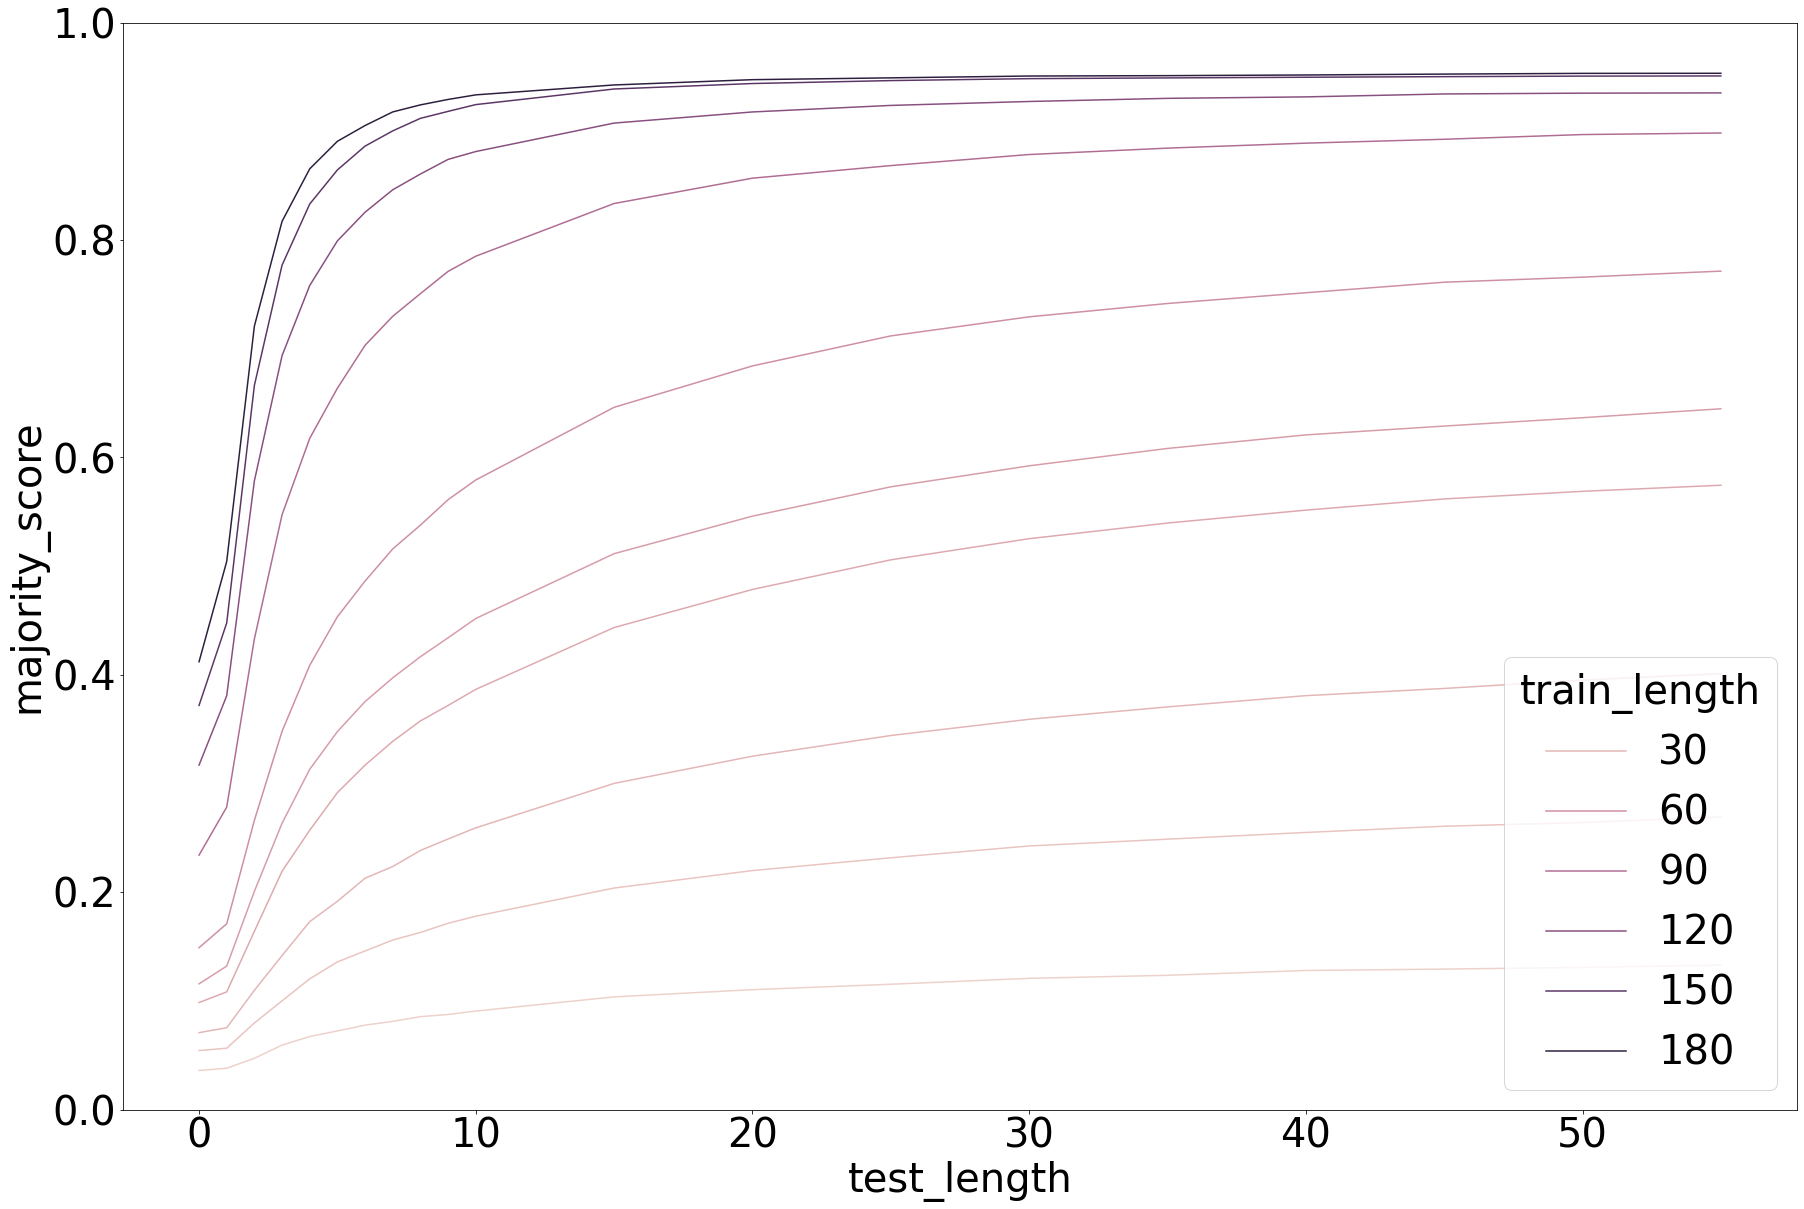

In [18]:
plt.rcParams.update({'font.size':40})
plt.figure(figsize=(30,20))
sns.lineplot(x='test_length',y='majority_score',hue='train_length',data=final_results)
plt.ylim([0,1])
plt.show()

In [19]:
final_results

,test_length,train_length,iteration,majority_score
0,0,10,1,0.036163
1,0,20,1,0.054481
2,0,30,1,0.070946
3,0,40,1,0.098666
4,0,50,1,0.115860
...,...,...,...,...
195,55,60,1,0.771412
196,55,90,1,0.898460
197,55,120,1,0.935339
198,55,150,1,0.950932
